<h2 class="section-heading">The Problem</h2>

Single neuron has limited computational power and hence we need a way to build a network of neurons to make a more complex model. In this post we will look into how to construct a neural network and try to solve the handwritten digit recognition problem. The goal is to decide which digit it represents when given a new image. 

<h2 class="section-heading">Understanding the Data</h2>

We'll use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Luckily, [John Myles White](https://github.com/johnmyleswhite/MNIST.jl) has already created a package to import this dataset in Julia. The MNIST dataset provides a training set of 60,000 handwritten digits and a test set of 10,000 handwritten digits. Each of the image has a size of 28×28 pixels. ![MNIST](files/img/nn/MNIST_digits.png)

In [1]:
#Pkg.update();
Pkg.add("MNIST");
Pkg.add("PyPlot")
#Pkg.installed();

For plotting, PyPlot is a good option. It provides a Julia interface to the Matplotlib plotting library from Python.

In [2]:
using MNIST
using PyPlot

Qt: Untested Windows version 10.0 detected!
INFO: Loading help data...


In [3]:
# ===================
# load training data
# ===================
X,y = traindata(); #X:(784x60000), y:(60000x1)
m = size(X, 2); # number of inputs

60000

<h2 class="section-heading">Training a model</h2>

We want to train a neural network with one input layer, one hidden layer and one output layer to recognize handwritten digits. Since the dataset contains 28×28 pixel images, our neural network will have $28*28=784$ input neurons, a variable number of hidden neurons and $10$ output neurons.

![2-layer-neuralNetwork](files/img/nn/nn_basic.png)

In [4]:
# ======================
# network setup
# ======================
inputLayerSize = size(X,1); # number of input features: 784
hiddenLayerSize = 25; # variable
outputLayerSize = 10; # number of output classes
# since we are doing multiclass classification: more than one output neurons
# representing each output as an array of size of the output layer
Y = zeros(outputLayerSize, m); #Y:(10,60000)
for i = 1:m
    Y[y[i]+1,i] = 1;
end

The appraoch to train a neural network is similar to what we have discussed in the [neuron post](http://lakshgupta.github.io/2015/05/21/ArtificialNeuron/).  But since now we have a network of neurons, the way we follow the steps is a bit different. We'll use the [backpropagation algorithm](http://www.cs.toronto.edu/~hinton/absps/naturebp.pdf). 

>Backpropagation works by approximating the non-linear relationship between the input and the output by adjusting the weight values internally. 
The operations of the Backpropagation neural networks can be divided into two steps: feedforward and Backpropagation. In the feedforward step, an input pattern is applied to the input layer and its effect propagates, layer by layer, through the network until an output is produced. The network's actual output value is then compared to the expected output, and an error signal is computed for each of the output nodes. Since all the hidden nodes have, to some degree, contributed to the errors evident in the output layer, the output error signals are transmitted backwards from the output layer to each node in the hidden layer that immediately contributed to the output layer. This process is then repeated, layer by layer, until each node in the network has received an error signal that describes its relative contribution to the overall error.
Once the error signal for each node has been determined, the errors are then used by the nodes to update the values for each connection weights until the network converges to a state that allows all the training patterns to be encoded. 
<p>- <a href="http://www.cse.unsw.edu.au/~cs9417ml/MLP2/BackPropagation.html">www.cse.unsw.edu.au</a></p>

We'll discuss more about the backpropagation algorithm later but first let's collect the simple tools which are required for training a neural network.

<h4 class="section-heading">Activation Function: $g$</h4>

The activation function of artificial neurons have to be differentiable and their derivative has to be non-zero so that the gradient descent learning algorithm can be applied. Considering [linear regression](http://lakshgupta.github.io/2015/05/27/LinearRegression/), using a linear activation function does not give us much advantage here. Linear function applied to a linear function is itself a linear function, and hence both the functions can be replaced by a single linear function. Moreover real world problems are generally more complex. A linear activation function may not be a good fit for the dataset we have. Therefore if the data we wish to model is non-linear then we need to account for that in our model. Sigmoid activation function is one of the reasonably good non-linear activation functions which we could use in our neural network.


$$sigmoid(z) = 1/(1 + e^{-z})$$

![sigmoid](files/img/nn/sigmoidGraph.png)

In [5]:
# ==============================================
# activation function: computes the sigmoid of z 
# z is the weighted sum of inputs
# ==============================================
function sigmoid(z)
    g = 1.0 ./ (1.0 + exp(-z));
    return g;
end

# computes the gradient of the sigmoid function evaluated at z
function sigmoidGradient(z)
  return sigmoid(z).*(1-sigmoid(z));
end

sigmoidGradient (generic function with 1 method)

<h4 class="section-heading">Cost Function: $J$</h4>

We used squared error (SE) cost function for performing [linear regression](http://lakshgupta.github.io/2015/05/27/LinearRegression/). But for training the neural network we'll use cross entropy (CE) cost function instead.

>The experimental results have shown that, in a comparable environment and with randomly initialized weights, the CE criterion allows to find a better local optimum than the SE criterion. The training of the SE system quickly got stuck in a worse local optimum where the gradient vanished and no further reduction of the classification errors was possible.
<p>- <a href="https://www-i6.informatik.rwth-aachen.de/publications/download/861/GolikPavelDoetschPatrickNeyHermann--Cross-Entropyvs.SquaredErrorTrainingaTheoreticalExperimentalComparison--2013.pdf">P. Golik, P. Doetsch, and H. Ney</a></p>

So considering:

$$J(\theta) = \frac{1}{m}(\sum_{i=1}^{m}cost(h_{\theta}(x^{(i)}),y^{(i)}))$$
where:
- $h_{\theta}(x^{(i)})$ is the predicted value (hypothesis)
- $y^{(i)}$ is the actual value (truth), and
$$\begin{eqnarray}
cost(h_{\theta}(x^{(i)}),y^{(i)})&=&\left\{
\begin{array}{l l}      
    -\log(h_{\theta}(x^{(i)}))   &   \mathrm{if} \: y=1 \\
    -\log(1-h_{\theta}(x^{(i)})) &  \mathrm{if}  \: y=0
\end{array}\right.,  \: h_{\theta}(x^{(i)})\in(0,1) \\ \nonumber
&=& - y^{(i)}\log{h_{\theta}(x^{(i)})} - (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))
\end{eqnarray}$$

Hence our cost function becomes:
$$J(\theta) = -\frac{1}{m}[\sum_{i=1}^{m} ( y^{(i)}\log{h_{\theta}(x^{(i)})} + (1-y^{(i)})\log({1-h_{\theta}(x^{(i)}))})]$$

We don't sum over the bias terms hence starting at 1 for the summation. The above equation for the cost function will work if we have a single neuron in the output layer. Let's generalize this cost function so that we could use it for $k$ neurons in the output layer. 
$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{i=1}^{k}[ y^{(i)}_k\log{(h_{\theta}(x^{(i)})_k)} + (1-y^{(i)}_k)\log({1-(h_{\theta}(x^{(i)}))_k)}]$$



<h4 class="section-heading">Regularization: $L^2$</h4>

Regularization helps us in handling the problem of overfitting. Most regularization approaches add a parameter norm penalty $\Omega(\theta)$ to the loss function $J$ to achieve better generalization of the model. In case of $L^2$ regularization, also known as weight decay, the penalty is equal to the sum of the square of all of the weight vectors.

$$\Omega(\theta) = \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}((\theta_{ji}^l)^2)$$ 

where 
- $\lambda>0$, is known as the regularization parameter
- $m$ is the size of our training set
- $L$ in the equation is the layer number
- $s$ is the neuron unit in the corresponding layer

>Regularizers work by trading increased bias for reduced variance. An effective regularizer is one that makes a proﬁtable trade, that is it reduces variance signiﬁcantly while not overly increasing the bias.
<p>- <a href="http://www.iro.umontreal.ca/~bengioy/dlbook/regularization.html">Yoshua Bengio, Ian Goodfellow and Aaron Courville</a></p>

The Wikipedia has a descent article on the [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff).

In [6]:
# weight regularization parameter
lambda = 3; 

# ===============================================
# cross entropy cost function with regularizarion
# ===============================================
function costFunction(truth, prediction)
    cost = zeros(m,1);
    for i=1:m
        cost[i,:] = (-Y[:,i]'*log(prediction[:,i])) - ((1-Y[:,i]')*log(1-prediction[:,i]));
    end
    # regularization term
    regularization = (lambda/(2*m))*(sum(sum(Theta1[2:end,:].^2)) + sum(sum(Theta2[2:end,:].^2)));

    return (1/m)*sum(cost) + regularization; # regularized cost
end

costFunction (generic function with 1 method)

<h4 class="section-heading">Backpropagation</h4>

Despite the name, [backpropagation algorithm](http://ufldl.stanford.edu/wiki/index.php/Backpropagation_Algorithm) consist of two phases:
- Feedforward 
- Backpropagation

The feedforward process is the same process we have been following in the previous posts. Using the feedforward process we calculate the weighted sum of inputs and apply the activation function to get an output as we move from layer to layer. In the end we come up with a output activation which could have some error as compared to the actual values. To have the output as close as possible to the actual values we use the backpropagation process to tune the weights.

![2-layer-neuralNetwork-feedforward](files/img/nn/ff_mnist.png)

Backpropagation is a way of computing gradients of expressions through recursive application of chain rule. We start from the output layer and go backwards calulating the gradient on the activations for each layer till the first hidden layer.

>From these gradients, which can be interpreted as an indication of how each layer’s output should change to reduce error, one can obtain the gradient on the parameters of each layer. The gradients on weights and biases can be immediately used as part of a stochastic gradient update (performing the update right after the gradients havebeen computed) or used with other gradient-based optimization methods.
<p>- <a href="http://www.iro.umontreal.ca/~bengioy/dlbook/regularization.html">Yoshua Bengio, Ian Goodfellow and Aaron Courville</a></p>

![2-layer-neuralNetwork-backpropagation](files/img/nn/bp_mnist.png)

Since we are learning/tuning weights ($\theta$), we want to evaluate: $\dfrac{\partial J}{\partial \theta^{(l)}}$, with $l$ as the layer number. Using the chain rule, we can solve the above partial derivative as:
$$\dfrac{\partial J}{\partial \theta^{(l)}} = \underbrace{\dfrac{\partial J}{\partial z^{(l+1)}}}_{1} \underbrace{\dfrac{\partial z^{(l+1)}}{\partial \theta^{(l)}}}_{2}$$

here, $z$ represents the input signal to a neuron which is the weighted sum of the outputs from the previous layer's neurons. Hence $(2)$ becomes:

$$\dfrac{\partial z^{(l+1)}}{\partial \theta^{(l)}} = a^{(l)}$$

where, $a$ is the value from applying activation function $g$ to $z$. Now let's look at $(1)$ and represent it as $\delta$. Since we start backpropagation from the last output layer, we can calculate the change in cost w.r.t weights as:
$$ \dfrac{\partial J}{\partial \theta^{(2)}} = \underbrace{\dfrac{\partial J}{\partial z^{(3)}}}_{\delta^{(3)}} \underbrace{\dfrac{\partial z^{(3)}}{\partial \theta^{(2)}}}_{a^{(2)}}$$

where,
$$ \begin{eqnarray}
\delta^{(3)} &=& \dfrac{\partial J}{\partial z^{(3)}} \\
&=& -[\frac{yg'(z^{(3)})}{g(z^{(3)})} + \frac{(1-y)(-g'(z^{(3)}))}{1-g(z^{(3)})}] \\
&=& g(z^{(3)}) - y \\ \\
&&(\text{for sigmoid, $g'(z) = g(z)(1-g(z))$})
\end{eqnarray}$$

In the squared error cost function, $\delta^{(3)}$ would have a factor of $g'(z^{(3)})$. This means that for a large difference between the truth and the hypothesis, the sigmoid gradient would become very low (sigmoid curve is flat at the top) and hence the learning of our model would be slow. Using the cross entropy cost function also saves us from that problem. In the current case the larger the error, the faster the neuron will learn. 

Similarly for the hidden layer we have:
$$ \dfrac{\partial J}{\partial \theta^{(1)}} = \underbrace{\dfrac{\partial J}{\partial z^{(2)}}}_{\delta^{(2)}} \underbrace{\dfrac{\partial z^{(2)}}{\partial \theta^{(1)}}}_{a^{(1)}}$$

where,
$$ \begin{eqnarray}
\delta^{(2)} &=& \dfrac{\partial J}{\partial z^{(2)}} \\
&=& \dfrac{\partial J}{\partial z^{(3)}} \dfrac{\partial z^{(3)}}{\partial g(z^{(2)})} \dfrac{\partial g(z^{(2)})}{\partial z^{(2)}} \\
&=& \delta^{(3)} \theta^{(2)} g'(z^{(2)})
\end{eqnarray}$$

The equations above may require special handling in order to perform matrix operations but basically we saw how the chain rule can be applied for the backpropagation algorithm.

We now have all the components for $\dfrac{\partial J}{\partial \theta^{l}}$, hence we can update the weights as:

$$\theta^{(l)} \leftarrow \theta^{(l)} - \frac{\alpha}{m} \dfrac{\partial J}{\partial \theta^{l}}$$
    
If the original cost function included a regularization term then we need to take it into account as well while taking the derivatives. Hence $\dfrac{\partial J}{\partial \theta^{l}}$ would also include the derivative of the regularization term, i.e. $\frac{\lambda}{m}\theta^{(l)}$. 

In [17]:
# including one bias neuron in input layer
# weights for the links connecting input layer to the hidden layer
Theta1 = randn(inputLayerSize+1, hiddenLayerSize); #(785x25)
# including one bias neuron in hidden layer
# weights for the links connecting hidden layer to the output layer
Theta2 = randn(hiddenLayerSize+1, outputLayerSize); #(26x10)
# learning rate
alpha = 0.9;
# number of iterations
epoch = 1500;
# cost per epoch
J = zeros(epoch,1);
# ====================================================================
# Train the neural network using feedforward-backpropagation algorithm
# ====================================================================
for i = 1:epoch
    # Feedforward #
    a1 = [ones(1,m), X]; # add one bias element (785x60000)
    z2 = Theta1'*a1; #(25x60000)
    a2 = sigmoid(z2);
    a2 = [ones(1,size(a2,2)), a2]; # add one bias element (26x60000)
    z3 = Theta2'*a2; #(10x60000)
    a3 = sigmoid(z3);
    
    # cost 
    J[i,:] = costFunction(Y, a3);
    
    # Backpropagation process #
    delta3 = (a3 - Y); #(10x60000)
    delta2 = (Theta2[2:end,:]*delta3).*sigmoidGradient(z2) ; #(25x10)*(10x60000).*(25x60000)
        
    #update weights
    reg_theta2 = (lambda*Theta2);
    reg_theta2[1,:] = 0;
    Theta2 = Theta2 - alpha*(a2*delta3' + reg_theta2)/m; 
    
    reg_theta1 = (lambda*Theta1);
    reg_theta1[1,:] = 0;
    Theta1 = Theta1 - alpha*(a1*delta2' + reg_theta1)/m;
end

If our implementation is correct, the cost of the predicted output after each iteration should drop. I'll cover another method (gradient check) in another post to validate our implementation. But for now let's check by plotting the cost per iteration.

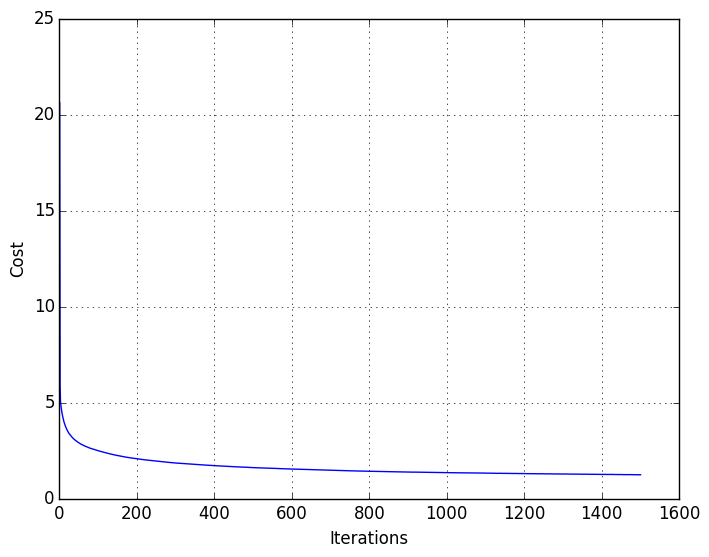

In [18]:
# plot the cost per iteration
plot(1:length(J), J)
xlabel("Iterations")
ylabel("Cost")
grid("on")

<h2 class="section-heading">Prediction and Accuracy</h2>

After training the model we'll check how well our model has learned all the weights to make a prediction. So we'll evaluate the performance on the train dataset first. We do it by following a way similar to the feedforward process. Consider that we now do not have randomly initialized weights but rather obtained after going through the backpropagation algorithm.

In [10]:
##########################################################################
# outputs the predicted label of X given the
# trained weights of a neural network (Theta1, Theta2)
# Similar to feedforward process.
##########################################################################
function predict(Theta1, Theta2, data)
    dataSz = size(data, 2); # size of the data
    p = zeros(dataSz, 1); # to save our prediction
    h1 = sigmoid(Theta1'*[ones(1,dataSz), data]); # hidded layer output
    h2 = sigmoid(Theta2'*[ones(1,size(h1,2)), h1]); # output layer
    # find the index with the max value in the array of size 10
    # subtract 1 from the index since we are using 1 to 
    # represent 0, 2 for 1 and so on (while calculating Y)
    for i=1:dataSz
        p[i,:] = indmax(h2[:,i])-1;
    end
    return p;
end

predict (generic function with 1 method)

In [19]:
# make prediction
pred = predict(Theta1, Theta2, X);

In [12]:
###############################################
# calculate the accuracy of the prediction
###############################################
function accuracy(truth, prediction)
    # calculate the % of predicted values
    # matching the actual values
    n = length(truth);
    sum =0;
    for i=1:n
        if truth[i,:] == prediction[i,:]
            sum = sum +1;
        end
    end
  return (sum/n)*100;
end

accuracy (generic function with 1 method)

In [20]:
# calculate accuracy
println("train accuracy: ", accuracy(y, pred));

train accuracy: 87.01333333333334


After calculating the accuracy on the train dataset, let's check the accuracy on the test dataset to be sure that we did not overfit the data. If there is too much difference then we might have to tune some parameters.

In [14]:
# ===============
# load test data
# ===============
XTest,yTest = testdata();

In [21]:
# make prediction
predTest = predict(Theta1, Theta2, XTest);

In [22]:
# calculate accuracy
println("test accuracy: ", accuracy(yTest, predTest));

test accuracy: 86.18


That's all folks! Now our model can make the prediction on any new handwritten digit in a similar way as we made the prediction on the test dataset. If we had let the training go on for longer iteration the accuracy would have been better, and there are other different ways as well to further improve the performance of the model or to make it run faster. I'll leave them for the coming posts.

<h2 class="section-heading">References:</h2>

- [Deep Learning in Neural Networks: An Overview](http://arxiv.org/abs/1404.7828)
- [Learning representations by back-propagating errors](http://www.cs.toronto.edu/~hinton/absps/naturebp.pdf)
- [Practical recommendations for gradient-based training of deep architectures](http://arxiv.org/abs/1206.5533)
- [Efficient BackProp](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf)
- [Coursera Machine Learning](https://class.coursera.org/ml-005)
- [Deep Learning](http://www.iro.umontreal.ca/~bengioy/dlbook/mlp.html)
- [Learning from Data](http://work.caltech.edu/slides/slides10.pdf)